In [1]:
from qiskit import QuantumCircuit, QuantumRegister, AncillaRegister, ClassicalRegister, Aer, execute
from qiskit.circuit.library.basis_change.qft import QFT
import numpy as np
import matplotlib.pyplot as plt
from svinspector import StatevectorInspector
from quantum_mlp import *

In [2]:
def get_vector_and_probs(circuit):
    statevector_simulator = Aer.get_backend('statevector_simulator')
    statevector_simulator.set_options(method='statevector_gpu')
    data = execute(circuit, statevector_simulator).result().data()['statevector']
    data = data.reshape(tuple(2 ** reg.size for reg in reversed(circuit.qregs)))
    data.real = np.where(np.abs(data.real) > 1.e-8, data.real, 0.)
    data.imag = np.where(np.abs(data.imag) > 1.e-8, data.imag, 0.)
    probs = np.square(np.abs(data))
    
    return data, probs

In [3]:
def print_prob_table(probs):
    for idx in sorted(probs):
        print(' '.join(str(k) for k in idx) + ':', probs[idx])

## Example full circuit

24 qubits


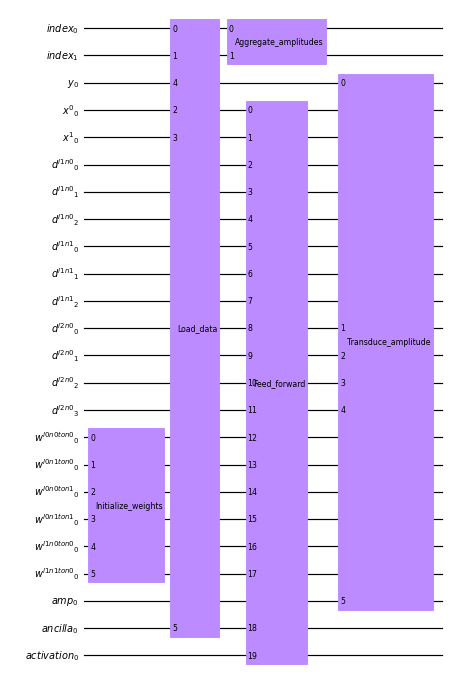

In [4]:
layer_nodes = [2, 2]
input_x = to_binary(np.arange(4), 2)
input_y = np.array([1, 0, 0, 1])
circuit = binary_mlp(layer_nodes, input_x, input_y)

print(circuit.num_qubits, 'qubits')
circuit.draw('mpl', scale=0.6)

In [5]:
data, probs = get_vector_and_probs(circuit)

svi = StatevectorInspector(data, circuit.qregs)
indices = {'index': 0, 'amp': 0}
for reg in circuit.qregs:
    if reg.name.startswith('w'):
        indices[reg.name] = np.newaxis
regs, probs = svi.get_probs(indices=indices, nonzero_only=True)
print(regs)
print_prob_table(probs)
print(max(probs.items(), key=lambda x: x[1]))

[1, 2, 3, 4, 5, 6]
['w^{l1n1ton0}', 'w^{l1n0ton0}', 'w^{l0n1ton1}', 'w^{l0n0ton1}', 'w^{l0n1ton0}', 'w^{l0n0ton0}']
0 0 0 0 0 0: 0.0019531250000000013
0 0 0 0 0 1: 0.0020483839462969384
0 0 0 0 1 0: 0.002048383946296939
0 0 0 0 1 1: 0.0019567857478843594
0 0 0 1 0 0: 0.0020483839462969384
0 0 0 1 0 1: 0.0021399821447095173
0 0 0 1 1 0: 0.002143642892593876
0 0 0 1 1 1: 0.002048383946296938
0 0 1 0 0 0: 0.0020483839462969384
0 0 1 0 0 1: 0.002143642892593876
0 0 1 0 1 0: 0.0021399821447095173
0 0 1 0 1 1: 0.002048383946296938
0 0 1 1 0 0: 0.0019567857478843594
0 0 1 1 0 1: 0.002048383946296938
0 0 1 1 1 0: 0.002048383946296937
0 0 1 1 1 1: 0.001981572306417788
0 1 0 0 0 0: 0.0019531250000000013
0 1 0 0 0 1: 0.001857866053703063
0 1 0 0 1 0: 0.001857866053703063
0 1 0 0 1 1: 0.0019494642521156406
0 1 0 1 0 0: 0.0020483839462969375
0 1 0 1 0 1: 0.001953125
0 1 0 1 1 0: 0.0019531249999999993
0 1 0 1 1 1: 0.002044723198412577
0 1 1 0 0 0: 0.0020483839462969384
0 1 1 0 0 1: 0.001953124999999

In [6]:
import collections
import pprint

results = collections.defaultdict(list)
results_prob = {}

maxw = None
maxp = 0.
for w in range(64):
    wbin = to_binary(w, 6)
    prob = 0.
    outputs = []
    for x, y in zip(range(4), [1, -1, -1, 1]):
        xbin = to_binary(x, 2)

        l1n0 = max(0, xbin[1] * (1 if wbin[5] == 1 else -1) + xbin[0] * (1 if wbin[4] == 1 else -1))
        l1n1 = max(0, xbin[1] * (1 if wbin[3] == 1 else -1) + xbin[0] * (1 if wbin[2] == 1 else -1))
        l2n0 = l1n0 * (1 if wbin[1] == 1 else -1) + l1n1 * (1 if wbin[0] == 1 else -1)
        l2n0 *= y
        outputs.append(l2n0)

        prob += np.square(np.cos(np.pi / 4. * (1. - l2n0 / 8.)))
    
    outputs = tuple(outputs)
    results[outputs].append(' '.join(str(w) for w in wbin))
    results_prob[outputs] = prob
        
    if prob > maxp:
        maxw = wbin
        maxp = prob
        
print(maxw, maxp)
for outputs in sorted(results):
    print(outputs, ':', results_prob[outputs], results[outputs])

[0 0 0 1 1 0] 2.195090322016129
(0, -2, -2, 4) : 1.9708699582281841 ['1 1 1 1 1 1']
(0, -2, -1, 2) : 1.902454838991936 ['1 1 1 1 1 0', '1 1 1 0 1 1']
(0, -2, 0, 0) : 1.8086582838174556 ['1 1 1 0 1 0']
(0, -1, -2, 2) : 1.902454838991936 ['1 1 1 1 0 1', '1 1 0 1 1 1']
(0, -1, -1, 0) : 1.804909677983872 ['1 1 0 1 1 0', '1 1 1 0 0 1']
(0, -1, -1, 2) : 1.9962513941664168 ['1 0 1 1 0 0', '1 1 1 1 0 0', '0 1 0 0 1 1', '1 1 0 0 1 1']
(0, -1, 0, 0) : 1.902454838991936 ['1 0 1 0 0 0', '1 1 1 0 0 0', '0 1 0 0 1 0', '1 1 0 0 1 0']
(0, -1, 0, 2) : 2.093796555174481 ['1 0 1 1 0 1', '0 1 0 1 1 1']
(0, -1, 1, 0) : 2.0000000000000004 ['0 1 0 1 1 0', '1 0 1 0 0 1']
(0, 0, -2, 0) : 1.8086582838174556 ['1 1 0 1 0 1']
(0, 0, -1, 0) : 1.902454838991936 ['1 0 0 1 0 0', '1 1 0 1 0 0', '0 1 0 0 0 1', '1 1 0 0 0 1']
(0, 0, -1, 2) : 2.093796555174481 ['1 0 1 1 1 0', '0 1 1 0 1 1']
(0, 0, 0, 0) : 2.0000000000000004 ['0 0 0 0 0 0', '1 0 0 0 0 0', '0 1 0 0 0 0', '1 1 0 0 0 0', '1 0 1 0 1 0', '0 1 1 0 1 0', '1 0 0 1

In [7]:
qregs = list(reversed(circuit.qregs))
num_regs = len(circuit.qregs)

ancilla_idx = next(i for i, reg in enumerate(qregs) if reg.name == 'ancilla')
activation_idx = next(i for i, reg in enumerate(qregs) if reg.name == 'activation')
index_idx = next(i for i, reg in enumerate(qregs) if reg.name == 'index')

print(data.shape, index_idx)

axis = list(range(num_regs))
axis.remove(ancilla_idx)
axis.remove(activation_idx)
print('Ancilla is clean:', np.sum(probs, axis=tuple(axis)))
#nonzero_indices = np.stack(data.nonzero()).T
#nonzero_indices = nonzero_indices[:, np.array(axis)]
#print('Nonzero indices:', nonzero_indices)
#nonzero_indices_index0 = np.array([indices for indices in nonzero_indices if indices[7] == 0])
#print(nonzero_indices_index0.shape)
#nonzero_indices_index1 = np.array([indices for indices in nonzero_indices if indices[7] == 1])
#print(nonzero_indices_index1.shape)
#nonzero_indices_index2 = np.array([indices for indices in nonzero_indices if indices[7] == 2])
#print(nonzero_indices_index2.shape)
#nonzero_indices_index3 = np.array([indices for indices in nonzero_indices if indices[7] == 3])
#print(nonzero_indices_index3.shape)
#print('Nonzero indices for input 0:', nonzero_indices_index0)
#print('Nonzero indices for input 1:', nonzero_indices_index1)
#print('Nonzero indices for input 2:', nonzero_indices_index2)
#print('Nonzero indices for input 3:', nonzero_indices_index3)
d = data[:, :, 0, :, :, 0, 0, :, :, 2, 1, 1, 1, 1, 1, 1]
print(d.shape)
print(np.stack(d.nonzero()).T)
axis = list(range(num_regs))
axis.remove(index_idx)
print('Probability per index:', np.sum(probs, axis=tuple(axis)))

(2, 2, 2, 2, 2, 2, 2, 2, 2, 16, 8, 8, 2, 2, 2, 4) 15


AxisError: axis 2 is out of bounds for array of dimension 0

In [ ]:
num_weight_regs = 0
full_layer_nodes = list(layer_nodes) + [1]
for il in range(len(layer_nodes)):
    num_weight_regs += full_layer_nodes[il] * full_layer_nodes[il + 1]

num_regs = len(circuit.qregs)
sum_axes = list(range(num_regs))
sum_axes.remove(0) # amp
sum_axes.remove(num_regs - 1 - num_weight_regs) # index
for i in range(num_weight_regs):
    sum_axes.remove(num_regs - 1 - i)
    
reduced_probs = np.sum(probs, axis=tuple(sum_axes))
weight_probs = reduced_probs[0, 0]
print(weight_probs)

## Validation

In [ ]:
print(input_x)
weights_0 = np.array([[-1, -1], [-1, 1], [1, -1], [1, 1]]).T
print(input_x @ weights_0)